In [3]:
import pandas as pd

# load the csv files
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

# look at first few rows of each dataset
print("trades data")
print(trades.head())

print("\nsentiment data")
print(sentiment.head())

# check column names, datatypes, and missing values
print("\ntrades info")
print(trades.info())

print("\nsentiment info")
print(sentiment.info())

# check rows and cols count
print(f"\ntrades shape: {trades.shape}")
print(f"sentiment shape: {sentiment.shape}")


trades data
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0

In [4]:
# convert trade timestamp into datetime
trades['trade_date'] = pd.to_datetime(trades['Timestamp IST'], format="%d-%m-%Y %H:%M")

# convert sentiment date into datetime
sentiment['date'] = pd.to_datetime(sentiment['date'], format="%Y-%m-%d")

# strip only the date part so merge works
trades['trade_date'] = trades['trade_date'].dt.date
sentiment['date'] = sentiment['date'].dt.date

# merge trades with sentiment on the date
merged = trades.merge(sentiment[['date','classification','value']], 
                      left_on='trade_date', right_on='date', how='left')

print(merged.head())
print(merged[['trade_date','classification','value']].sample(5))


                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec0945

In [5]:
# how many trades got a sentiment label
print(merged['classification'].value_counts(dropna=False))

# quick sample to eyeball results
print(merged[['trade_date','Closed PnL','classification']].sample(10))

# check missing sentiment
missing = merged['classification'].isna().sum()
print(f"\nNumber of trades without sentiment: {missing}")


Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
NaN                  6
Name: classification, dtype: int64
        trade_date  Closed PnL classification
21525   2024-04-10  247.054995  Extreme Greed
125751  2025-01-22    0.000000  Extreme Greed
184424  2025-03-26    0.000000        Neutral
172531  2025-02-25   -0.679671           Fear
106375  2025-01-06    0.000000  Extreme Greed
128091  2025-04-16    3.612392           Fear
26158   2025-01-20    0.000000  Extreme Greed
116310  2025-02-15    5.905928        Neutral
208142  2025-04-20    0.000000           Fear
73852   2025-03-11    0.000000   Extreme Fear

Number of trades without sentiment: 6


In [6]:
# drop rows without sentiment
merged = merged.dropna(subset=['classification'])

# trades per sentiment
print(merged['classification'].value_counts())

# average PnL per sentiment
print("\nAvg PnL per sentiment")
print(merged.groupby('classification')['Closed PnL'].mean())

# win rate per sentiment (fraction of profitable trades)
print("\nWin rate per sentiment")
print(
    merged.groupby('classification')['Closed PnL']
          .apply(lambda x: (x > 0).mean())
)


Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: classification, dtype: int64

Avg PnL per sentiment
classification
Extreme Fear     34.537862
Extreme Greed    67.892861
Fear             54.290400
Greed            42.743559
Neutral          34.307718
Name: Closed PnL, dtype: float64

Win rate per sentiment
classification
Extreme Fear     0.370607
Extreme Greed    0.464943
Fear             0.420768
Greed            0.384828
Neutral          0.396991
Name: Closed PnL, dtype: float64


<Figure size 800x500 with 0 Axes>

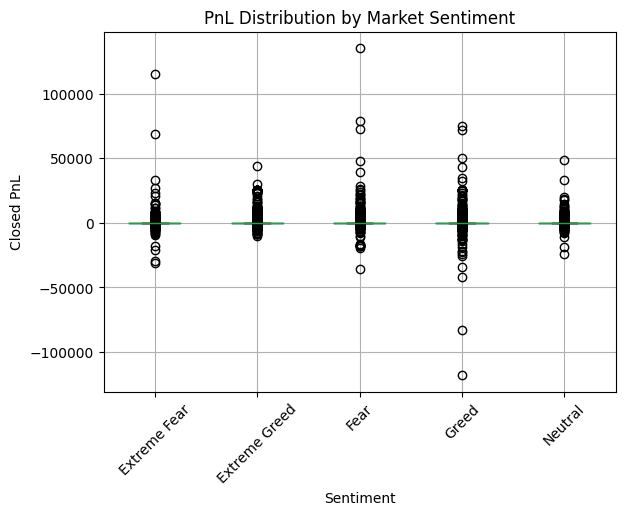

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
merged.boxplot(column="Closed PnL", by="classification")
plt.title("PnL Distribution by Market Sentiment")
plt.suptitle("")
plt.xlabel("Sentiment")
plt.ylabel("Closed PnL")
plt.xticks(rotation=45)
plt.show()


In [8]:
if 'leverage' in merged.columns:
    # average leverage per sentiment
    print("\nAvg leverage per sentiment")
    print(merged.groupby('classification')['leverage'].mean())

    # leverage distribution plot
    plt.figure(figsize=(8,5))
    merged.boxplot(column="leverage", by="classification")
    plt.title("Leverage Distribution by Market Sentiment")
    plt.suptitle("")
    plt.xlabel("Sentiment")
    plt.ylabel("Leverage")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No leverage column found in this dataset")


No leverage column found in this dataset


Direction       Auto-Deleveraging   Buy  Close Long  Close Short  \
classification                                                     
Extreme Fear                    0   807        6241         3117   
Extreme Greed                   0  5132        7186         6497   
Fear                            0  3207       17260         9221   
Greed                           8  4685        7998        11322   
Neutral                         0  2885        9993         5850   

Direction       Liquidated Isolated Short  Long > Short  Open Long  \
classification                                                       
Extreme Fear                            0             5       7005   
Extreme Greed                           0             7       6300   
Fear                                    0            14      17824   
Greed                                   1            16       8544   
Neutral                                 0            15      10222   

Direction       Open Short  Sell

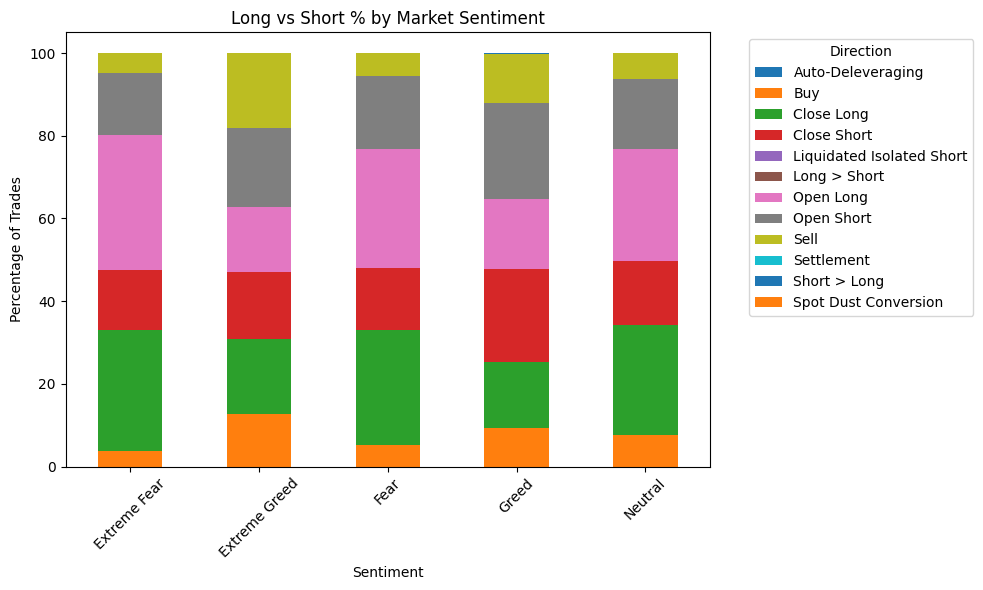

In [9]:
# count of trade directions per sentiment
direction_counts = merged.groupby(['classification','Direction']).size().unstack(fill_value=0)
print(direction_counts)

# percentage split of long vs short in each sentiment
direction_pct = direction_counts.div(direction_counts.sum(axis=1), axis=0) * 100
print("\nDirection % split by sentiment")
print(direction_pct)

# stacked bar plot with legend on the side
ax = direction_pct.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title("Long vs Short % by Market Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Percentage of Trades")
plt.xticks(rotation=45)

# move legend outside chart area
plt.legend(title="Direction", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [10]:
# average PnL per sentiment and trade direction
pnl_by_dir = merged.groupby(['classification','Direction'])['Closed PnL'].mean().unstack()
print("Avg PnL per sentiment & direction")
print(pnl_by_dir)

# win rate per sentiment and direction
win_by_dir = merged.groupby(['classification','Direction'])['Closed PnL'].apply(lambda x: (x>0).mean()).unstack()
print("\nWin rate per sentiment & direction")
print(win_by_dir)


Avg PnL per sentiment & direction
Direction       Auto-Deleveraging  Buy  Close Long  Close Short  \
classification                                                    
Extreme Fear                  NaN  0.0   81.197371   123.400238   
Extreme Greed                 NaN  0.0   61.830783    28.970490   
Fear                          NaN  0.0   83.000111   207.676658   
Greed                 7184.807003  0.0   88.958554    55.195496   
Neutral                       NaN  0.0   52.815787    94.796313   

Direction       Liquidated Isolated Short  Long > Short  Open Long  \
classification                                                       
Extreme Fear                          NaN      1.331956        0.0   
Extreme Greed                         NaN    120.600968        0.0   
Fear                                  NaN      4.795642        0.0   
Greed                        -12752.91304     22.711911        0.0   
Neutral                               NaN     47.332193        0.0   

Direc

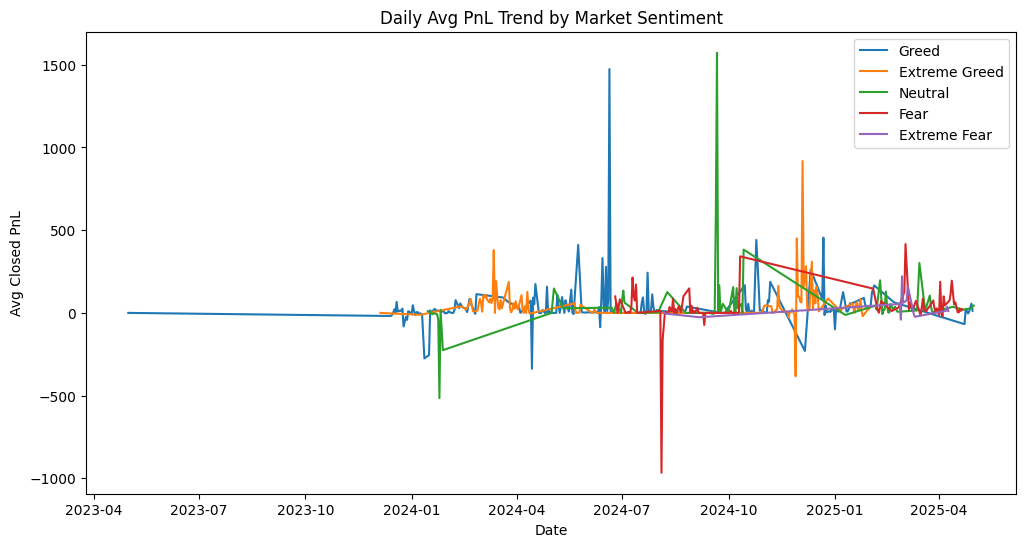

In [11]:
# average daily pnl grouped by date and sentiment
daily_pnl = merged.groupby(['trade_date','classification'])['Closed PnL'].mean().reset_index()

# line plot of PnL trend by sentiment
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for s in daily_pnl['classification'].unique():
    subset = daily_pnl[daily_pnl['classification'] == s]
    plt.plot(subset['trade_date'], subset['Closed PnL'], label=s)

plt.title("Daily Avg PnL Trend by Market Sentiment")
plt.xlabel("Date")
plt.ylabel("Avg Closed PnL")
plt.legend()
plt.show()


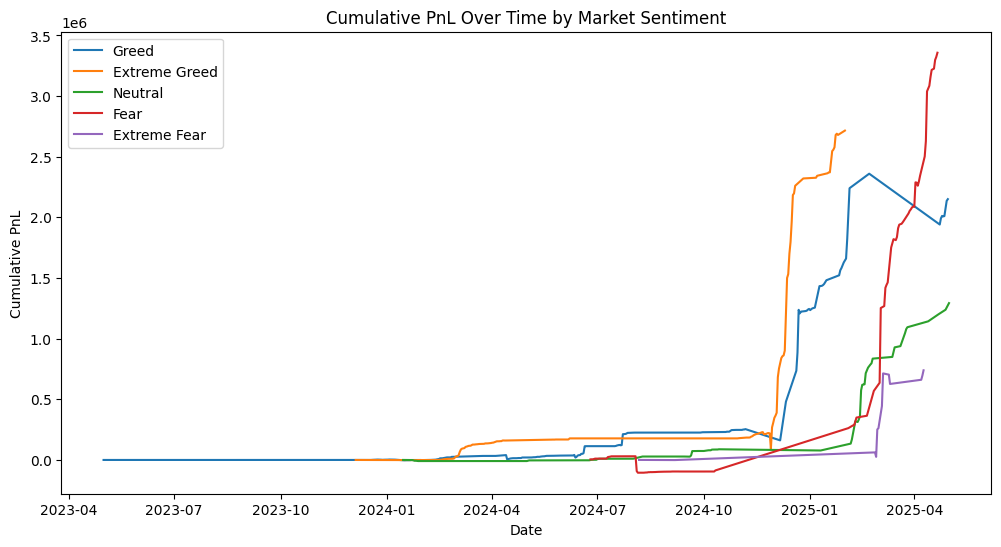

In [12]:
# calculate daily total pnl per sentiment
daily_total_pnl = merged.groupby(['trade_date','classification'])['Closed PnL'].sum().reset_index()

# sort by date
daily_total_pnl = daily_total_pnl.sort_values('trade_date')

# cumulative sum per sentiment
daily_total_pnl['cumulative_pnl'] = daily_total_pnl.groupby('classification')['Closed PnL'].cumsum()

# plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for s in daily_total_pnl['classification'].unique():
    subset = daily_total_pnl[daily_total_pnl['classification'] == s]
    plt.plot(subset['trade_date'], subset['cumulative_pnl'], label=s)

plt.title("Cumulative PnL Over Time by Market Sentiment")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()


In [13]:
from scipy.stats import ttest_ind

# pick two groups: Fear vs Greed
fear_pnl = merged[merged['classification'] == 'Fear']['Closed PnL']
greed_pnl = merged[merged['classification'] == 'Greed']['Closed PnL']

t_stat, p_val = ttest_ind(fear_pnl, greed_pnl, equal_var=False)

print("Fear vs Greed PnL comparison")
print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.5f}")

# quick helper: check if significant
if p_val < 0.05:
    print("Result: Statistically significant difference ")
else:
    print("Result: Not significant")


Fear vs Greed PnL comparison
T-statistic: 1.851, P-value: 0.06415
Result: Not significant


In [14]:
def compare_sentiments(sent1, sent2):
    from scipy.stats import ttest_ind
    s1 = merged[merged['classification'] == sent1]['Closed PnL']
    s2 = merged[merged['classification'] == sent2]['Closed PnL']
    t_stat, p_val = ttest_ind(s1, s2, equal_var=False)
    print(f"{sent1} vs {sent2} PnL comparison")
    print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.5f}")
    if p_val < 0.05:
        print("=> Significant difference")
    else:
        print("=> Not significant")
    print()

# example usage
compare_sentiments("Extreme Greed", "Neutral")
compare_sentiments("Extreme Greed", "Extreme Fear")
compare_sentiments("Fear", "Extreme Fear")


Extreme Greed vs Neutral PnL comparison
T-statistic: 7.193, P-value: 0.00000
=> Significant difference

Extreme Greed vs Extreme Fear PnL comparison
T-statistic: 3.851, P-value: 0.00012
=> Significant difference

Fear vs Extreme Fear PnL comparison
T-statistic: 2.289, P-value: 0.02208
=> Significant difference



In [15]:
from scipy.stats import chi2_contingency

# build a simple contingency table: sentiment x direction
direction_table = pd.crosstab(merged['classification'], merged['Direction'])

print("Contingency Table: sentiment x direction")
print(direction_table)

# chi-square test
chi2, p, dof, expected = chi2_contingency(direction_table)

print("\nChi-square Test Result")
print(f"Chi2: {chi2:.3f}, p-value: {p:.5f}")

if p < 0.05:
    print("=> Trade direction depends on sentiment (significant)")
else:
    print("=> No strong link between trade direction and sentiment")


Contingency Table: sentiment x direction
Direction       Auto-Deleveraging   Buy  Close Long  Close Short  \
classification                                                     
Extreme Fear                    0   807        6241         3117   
Extreme Greed                   0  5132        7186         6497   
Fear                            0  3207       17260         9221   
Greed                           8  4685        7998        11322   
Neutral                         0  2885        9993         5850   

Direction       Liquidated Isolated Short  Long > Short  Open Long  \
classification                                                       
Extreme Fear                            0             5       7005   
Extreme Greed                           0             7       6300   
Fear                                    0            14      17824   
Greed                                   1            16       8544   
Neutral                                 0            15      1

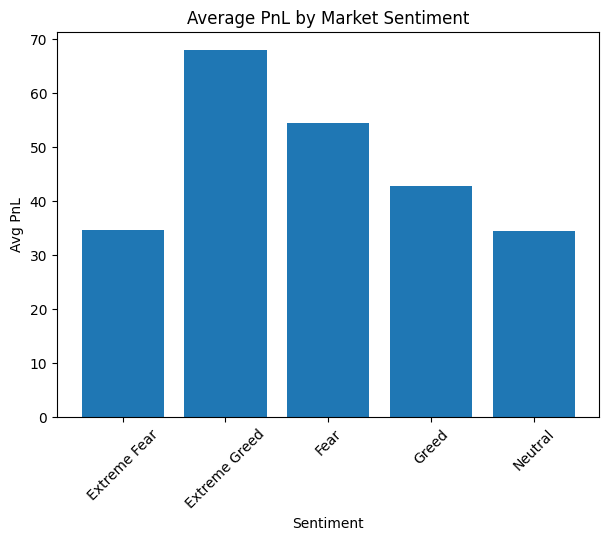

In [16]:
avg_pnl = merged.groupby('classification')['Closed PnL'].mean().reset_index()

plt.figure(figsize=(7,5))
plt.bar(avg_pnl['classification'], avg_pnl['Closed PnL'])
plt.title("Average PnL by Market Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Avg PnL")
plt.xticks(rotation=45)
plt.show()


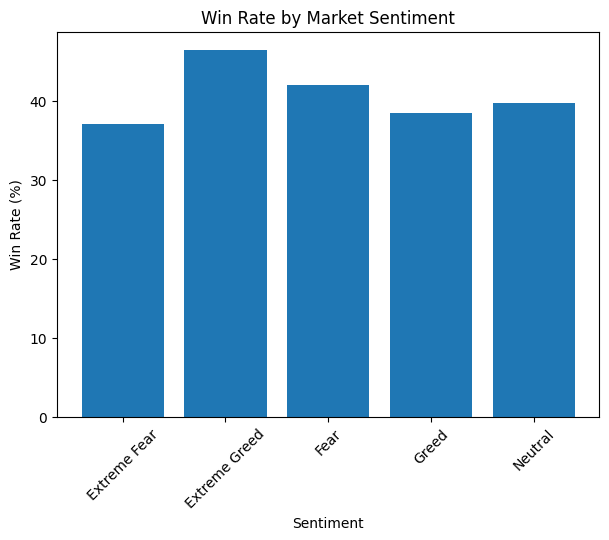

In [17]:
win_rate = merged.groupby('classification')['Closed PnL'].apply(lambda x: (x>0).mean()).reset_index()

plt.figure(figsize=(7,5))
plt.bar(win_rate['classification'], win_rate['Closed PnL']*100)
plt.title("Win Rate by Market Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Win Rate (%)")
plt.xticks(rotation=45)
plt.show()


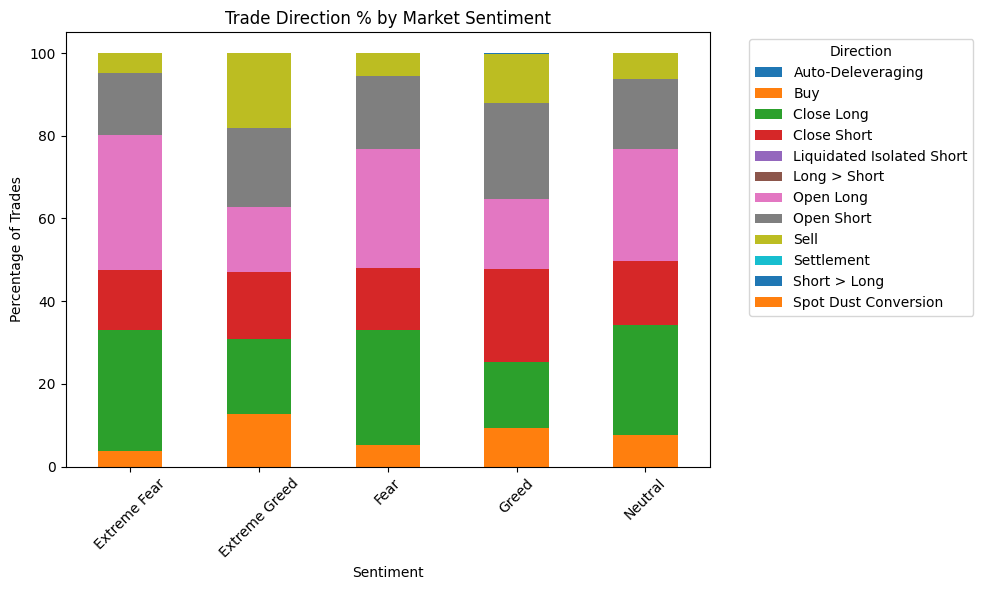

In [18]:
direction_pct = pd.crosstab(merged['classification'], merged['Direction'], normalize='index') * 100

ax = direction_pct.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title("Trade Direction % by Market Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Percentage of Trades")
plt.xticks(rotation=45)

# move legend to the right side
plt.legend(title="Direction", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [19]:
# export merged dataset to csv
merged.to_csv("cleaned_trades_with_sentiment.csv", index=False)
print("CSV file saved successfully!")


CSV file saved successfully!
